In [1]:
.libPaths("/home/groups/candes/Software/miniconda2/envs/ukb/lib/R/library")
suppressMessages(library(tidyverse))
suppressMessages(library(superheat))
suppressMessages(library(qqman))
suppressMessages(library(ggrepel))
suppressMessages(library(latex2exp))
suppressMessages(library(cowplot))

scratch <- "/scratch/PI/candes/ukbiobank_tmp"

## Load annotations

In [2]:
# Functional annotations

annotations.func.file <- "/home/groups/candes/genetic_annotations/GM12878_ChromHMM_hg19.txt"
Annotations.func.raw <- read_tsv(annotations.func.file, col_types=cols(`#bin`=col_integer(), 
                                                                     chromStart=col_integer(), 
                                                                     chromEnd=col_integer(),
                                                                     name=col_factor(),
                                                                     score=col_integer(), 
                                                                     thickStart=col_integer(), 
                                                                     thickEnd=col_integer()))

# Remove weird chromosomes and convert colors
valid.chrom <- paste("chr", seq(1,22), sep="")
Annotations.func <- Annotations.func.raw %>%
    filter(chrom %in% valid.chrom) %>% mutate(chrom=parse_number(as.character(chrom))) %>%
    separate(itemRgb, into=c("itemR", "itemG", "itemB"), sep=",", convert=T) %>%
    mutate(itemColor = rgb(red=itemR, blue=itemB, green=itemG, maxColorValue=255)) %>%
    arrange(chrom, chromStart)

# Extract color map
annotation.color.map <- Annotations.func %>% group_by(name, itemColor) %>% summarise() %>% 
    ungroup() %>%
    mutate(name.num=parse_number(as.character(name))) %>% 
    mutate(label=gsub("\\d+_", "",name), label=gsub(fixed("_"), " ",label)) %>%
    arrange(name.num)

# Convert names to factors according to color maps
Annotations.func <- Annotations.func %>%
    mutate(name=factor(name, levels=annotation.color.map$name, labels=annotation.color.map$name))

In [3]:
# Gene annotations
annotations.genes.file <- "/home/groups/candes/genetic_annotations/NCBI_genes_hg19.txt"
Annotations.genes.raw <- read_tsv(annotations.genes.file, col_types=cols(`#bin`=col_integer(), 
                                                                     txStart=col_integer(), 
                                                                     txEnd=col_integer(), 
                                                                     cdsStart=col_integer(), 
                                                                     cdsEnd=col_integer(), 
                                                                     exonCount=col_integer(), 
                                                                     score=col_integer(), 
                                                                     .default=col_character()))

# Remove weird chromosomes
valid.chrom <- paste("chr", seq(1,22), sep="")
Annotations.genes <- Annotations.genes.raw %>%
    filter(chrom %in% valid.chrom) %>% mutate(chrom=parse_number(as.character(chrom))) %>%
    arrange(chrom)

#colnames(Annotations.genes)
#Annotations.genes %>% head

# Split rows corresponding to same gene but different exons
Exons <- Annotations.genes %>% 
    separate_rows(exonStarts, exonEnds, exonFrames, sep=",", convert=TRUE) %>%
    drop_na()

# Pick the canonical transcripts
# That is, for each unique "name2", keep only the rows corresponding to the "name" 
# with the largest sum of exon lengths
Exons.canonical <- Exons %>%
    mutate(exonLength=exonEnds-exonStarts) %>%
    group_by(name, name2) %>% summarise(Length=sum(exonLength)) %>%
    ungroup() %>% group_by(name2) %>% top_n(1, Length) %>%
    inner_join(Exons, by=c("name", "name2")) 


## Load discoveries

In [4]:
phenotype <- "height"

# Knockoffs
resolution.list <- c("Radj2", "Radj5", "Radj10", "Radj20", "Radj50", "Radj75", "Radj100")
phenotype.list <- c(phenotype)

Params <- expand.grid(Resolution=resolution.list, Phenotype=phenotype.list) %>% as_tibble()

Discoveries <- lapply(1:nrow(Params), function(idx) {
    resolution <- Params$Resolution[idx]
    phenotype <- Params$Phenotype[idx]
    #cat(sprintf("Loading list of discoveries for %s at resolution %s...\n", phenotype, resolution))
    
    # Load LMM discoveries (if available)
    lmm.file <- sprintf("%s/discoveries/%s_lmm_regions.txt", scratch, phenotype)
    if(resolution=="Radj2" && file.exists(lmm.file)) {
        Discoveries.LMM <- read_delim(lmm.file, delim=" ", col_types=cols()) %>%
            mutate(Phenotype=phenotype, Method="LMM", Importance=-log10(P), Resolution="GWAS") %>%
            select(-c("P"))
        #cat(sprintf("Found %d discoveries for %s made with LMM.\n", nrow(Discoveries.LMM), phenotype))
    } else {
        #cat(sprintf("Discoveries for %s made with LMM are not available.\n", phenotype))
        Discoveries.LMM <- tibble()
    }
    
    # Load knockoffs discoveries (if available)
    knockoffs.file <- sprintf("%s/discoveries/%s_knockoffs_%s.txt", scratch, phenotype, resolution)
    if(file.exists(knockoffs.file)) {
        Discoveries.knockoffs <- read_delim(knockoffs.file, delim=" ", col_types=cols()) %>%
            mutate(Phenotype=phenotype, Method="Knockoffs", Importance=W, Resolution=resolution) %>%
            select(-c("W", "Group"))
        #cat(sprintf("Found %d discoveries for %s made with knockoffs at resolution %s.\n", 
        #            nrow(Discoveries.knockoffs), phenotype, resolution))
    } else {
        #cat(sprintf("Discoveries for %s made with knockoffs at resolution %s are not available.\n", 
        #    phenotype, resolution))
        Discoveries.knockoffs <- tibble()
    }
    
    # Combine results
    return(rbind(Discoveries.LMM,Discoveries.knockoffs))
})
Discoveries <- do.call("rbind", Discoveries) %>%
    mutate(Resolution=factor(Resolution, labels=c("GWAS", resolution.list), levels=c("GWAS", resolution.list)))

Discoveries %>% mutate(BP.width=BP.max-BP.min) %>%
    group_by(Phenotype, Resolution) %>%
    summarise(Discoveries=n(), Size=median(Size), BP.width=median(BP.width)/1e6)

Phenotype,Resolution,Discoveries,Size,BP.width
height,GWAS,1685,16,0.4693380
height,Radj2,3252,61,0.2543695
height,Radj5,2007,31,0.1287760
height,Radj10,785,18,0.0671260
height,Radj20,391,8,0.0301760
height,Radj50,335,3,0.0086720
height,Radj75,327,2,0.0018920
height,Radj100,183,1,0.0000000


In [5]:
# Load LMM p-values
lmm.file <- sprintf("%s/analysis/bolt/%s_stats.txt", scratch, phenotype)
LMM <- read_delim(lmm.file, delim="\t", col_types=cols()) %>% as_tibble()
if("P_BOLT_LMM" %in% colnames(LMM)) {
    LMM <- LMM %>% mutate(P=P_BOLT_LMM)
} else {
    LMM <- LMM %>% mutate(P=P_BOLT_LMM_INF)
}

# Load clumped LMM results
lmm.file <- sprintf("%s/discoveries/%s_lmm_variants.txt", scratch, phenotype)
LMM.clumped <- read_delim(lmm.file, delim=" ", col_types=cols()) %>%
    mutate(Phenotype=phenotype, Method="LMM", Importance=-log10(P), Resolution="GWAS") %>%
    select(-c("P"))

## Plot discoveries and exons

In [6]:
# Pick a discovery and define a window around it
window.lead <- Discoveries %>% filter(Method=="Knockoffs", CHR==20, Resolution=="Radj50") %>%
    arrange(desc(Importance)) %>% head(1)
window.lead

window.width <- 5*1e5
window.chr <- window.lead$CHR
window.left <- window.lead$BP.lead - window.width
window.right <- window.lead$BP.lead + window.width
cat(sprintf("Selected window on chromosome %d between %.2f and %.2f Mb.\n", 
            window.chr, window.left/1e6, window.right/1e6))

CHR,SNP.lead,BP.lead,BP.min,BP.max,BP.width,Size,Phenotype,Method,Importance,Resolution
20,rs143384,34025756,34025756,34025983,227,3,height,Knockoffs,0.3148237,Radj50


Selected window on chromosome 20 between 33.53 and 34.53 Mb.


In [29]:
# Pick a discovery and define a window around it
window.lead <- LMM %>% filter(CHR==19) %>% arrange(P) %>% head(1)
window.lead

window.width <- 5*1e5
window.chr <- window.lead$CHR
window.left <- window.lead$BP - window.width
window.right <- window.lead$BP + window.width
cat(sprintf("Selected window on chromosome %d between %.2f and %.2f Mb.\n", 
            window.chr, window.left/1e6, window.right/1e6))

SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,F_MISS,BETA,SE,P_BOLT_LMM_INF,P_BOLT_LMM,P
rs12976923,19,2173136,0.0753696,G,A,0.61182,0.00162287,-0.226011,0.0124025,3.4e-74,7.2e-78,7.2e-78


Selected window on chromosome 19 between 1.67 and 2.67 Mb.


[1] 795

There are 8 knockoff discoveries within this window.
There are 410 LMM pvalues within this window, 19 of which are significant.
There are 288 exons within this window, divided into 37 genes.
There are 630 functional annotations within this window.


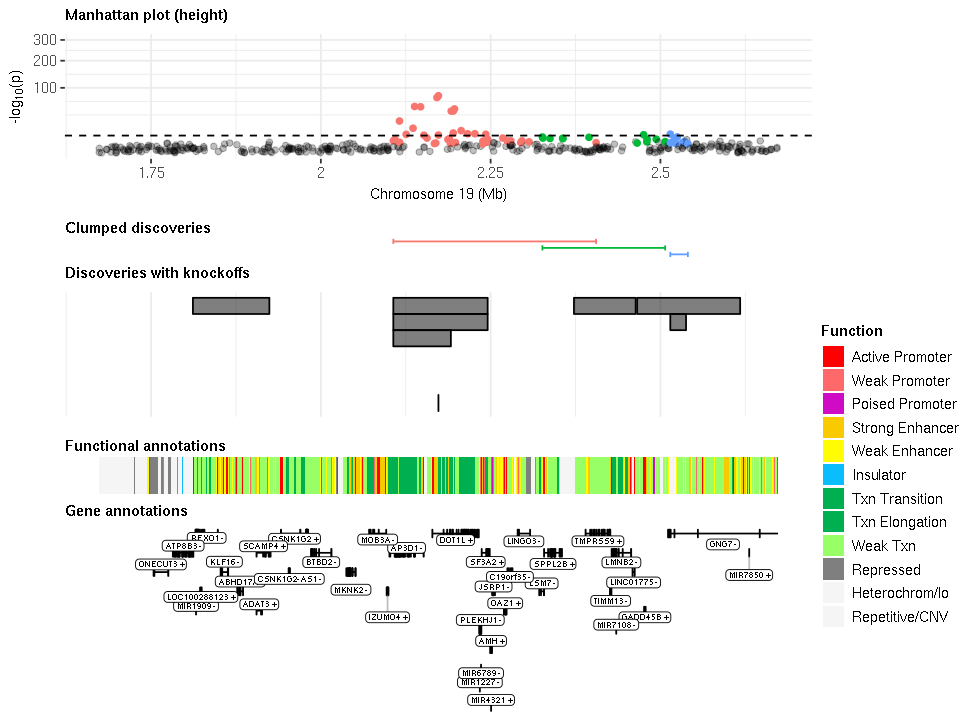

In [30]:
source("../utils/utils_clumping.R")
source("utils_annotations.R")

LMM.clumped.consolidated <- LMM.clumped %>% 
    group_by(Phenotype, Method, Resolution) %>%
    consolidate_clumps_variants()

length(unique(LMM.clumped.consolidated$SNP.lead))

plot.file <- sprintf("figures/annotations_%s_chr%s_full.png", phenotype, window.chr)
p.towers <- plot_sears_tower(window.chr, window.left, window.right, Discoveries, 
                             LMM, LMM.clumped, 
                 Annotations.func, Exons.canonical, plot.file=plot.file)

options(repr.plot.width=8, repr.plot.height=6)
p.towers

There are 4 knockoff discoveries within this window.
There are 410 LMM pvalues within this window, 19 of which are significant.
There are 288 exons within this window, divided into 37 genes.
There are 630 functional annotations within this window.


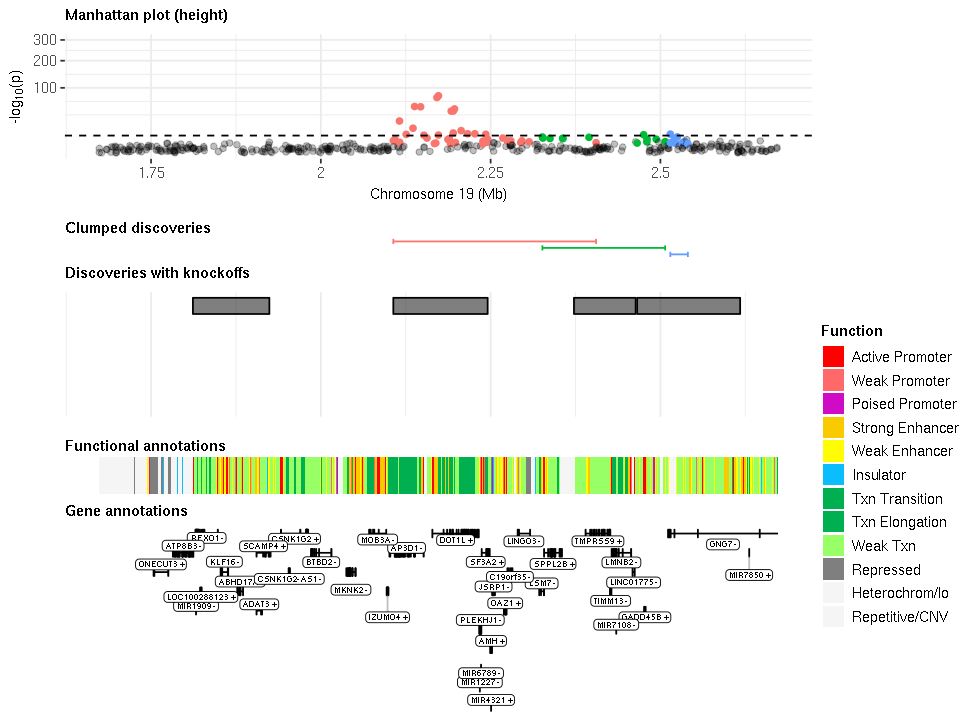

In [31]:
source("../utils/utils_clumping.R")
source("utils_annotations.R")

Discoveries.first <- Discoveries %>% filter(Resolution=="Radj2")

plot.file <- sprintf("figures/annotations_%s_chr%s_partial.png", phenotype, window.chr)
p.towers <- plot_sears_tower(window.chr, window.left, window.right, Discoveries.first, 
                             LMM, LMM.clumped, 
                 Annotations.func, Exons.canonical, plot.file=plot.file)

options(repr.plot.width=8, repr.plot.height=6)
p.towers

[1] 1072

There are 5 knockoff discoveries within this window.
There are 410 LMM pvalues within this window, 19 of which are significant.
There are 288 exons within this window, divided into 37 genes.
There are 630 functional annotations within this window.


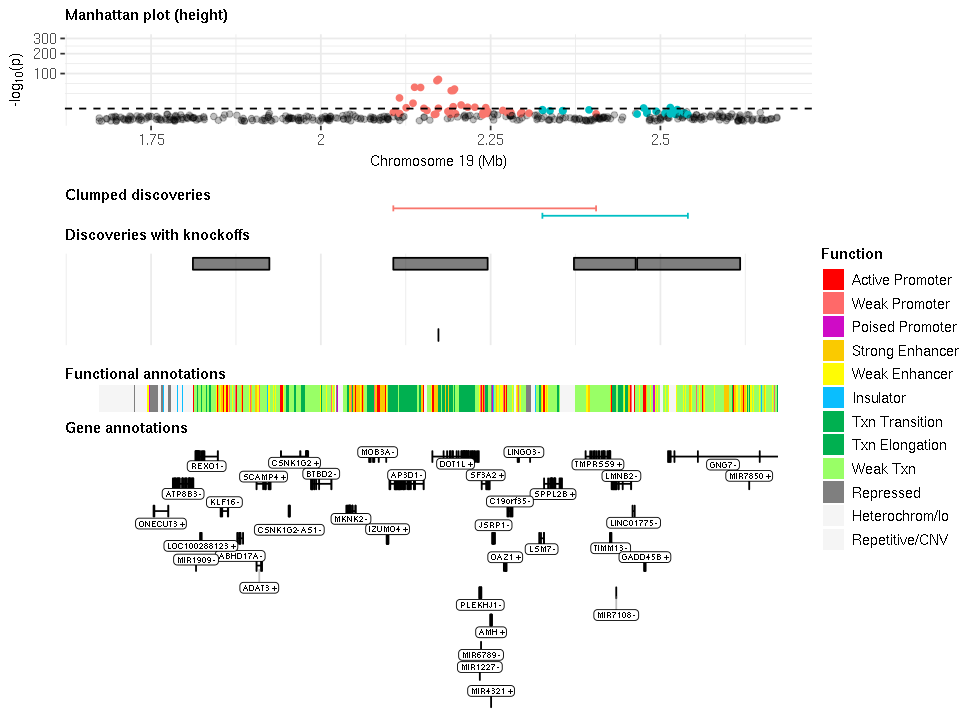

In [112]:
LMM.clumped.consolidated <- LMM.clumped %>% 
    group_by(Phenotype, Method, Resolution) %>%
    consolidate_clumps_variants(threshold=-log10(5e-8))

length(unique(LMM.clumped.consolidated$SNP.lead))

plot.file <- sprintf("figures/annotations_%s_chr%s_partial.png", phenotype, window.chr)
p.towers <- plot_sears_tower(window.chr, window.left, window.right, Discoveries, 
                             LMM, LMM.clumped.consolidated, 
                 Annotations.func, Exons.canonical, plot.file=plot.file)

options(repr.plot.width=8, repr.plot.height=6)
p.towers

[1] 1685

There are 5 knockoff discoveries within this window.
There are 410 LMM pvalues within this window, 19 of which are significant.
There are 288 exons within this window, divided into 37 genes.
There are 630 functional annotations within this window.


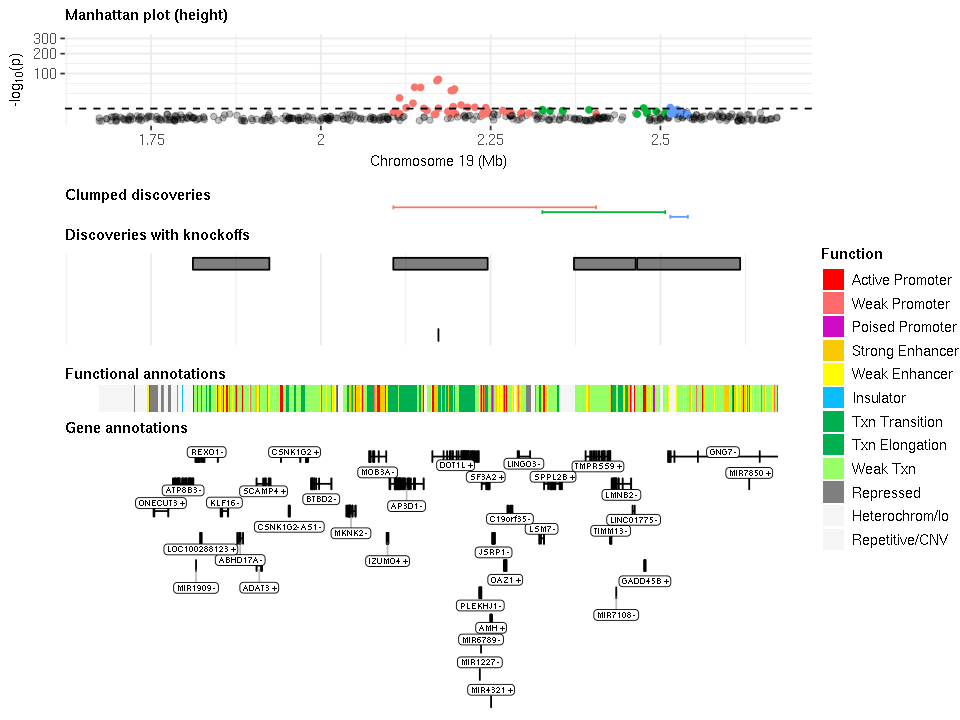

In [113]:
length(unique(LMM.clumped$SNP.lead))

plot.file <- sprintf("figures/annotations_%s_chr%s_plink.png", phenotype, window.chr)
p.towers <- plot_sears_tower(window.chr, window.left, window.right, Discoveries, 
                             LMM, LMM.clumped, 
                 Annotations.func, Exons.canonical, plot.file=plot.file)

options(repr.plot.width=8, repr.plot.height=6)
p.towers